# COMP3032 – Machine Learning

## Student Info
- Full Name: Huynh Cat Phi LE
- Student ID: 22026908
- Subject code: COMP3032 Machine Learning
- Assignment: Assessment 2 - Assignment 2

## Main objective

<em>We will build a manifold learning or sometimes called dimensionality reduction model on CIFAR-10 images so that we can visualise images in low dimensional space, say in 2D plane. In this assignment, we use image data CIFAR-10. The CIFAR-10 dataset is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. See https://www.cs.toronto.edu/~kriz/cifar.html for details. As we use images, you need to use convolutional neural networks instead of simple MLP. You are free to choose the structure of the CNN, for example, the number of layers, activation functions etc. In terms of the dimensionality of the manifold, we fix it to be 2, meaning the middle layer (bottle neck layer) of your autoencoder should have only 2 units. The output of this bottleneck layer is usually called the representation of the input. Refer to tutorial materials for learning module 10 and 12 for autoencoder.</em>

## Environment Setup

Import neccesary files for the analysis and set a fixed random seed to ensure that the random numbers generated by PyTorch and numpy will be the same every time the code is run. 

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
from torch.optim import Adam
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Set fixed random number seed
torch.manual_seed(22026908)
np.random.seed(22026908)

Load the CIFAR-10 dataset from my local file, convert the images to tensors using `transforms.ToTensor()` function.

In [82]:
dataset_path = "" # cifar-10-batches-py is included in the same local root directory, modify this path as needed
dataset = CIFAR10(root=dataset_path, download=False, transform=transforms.ToTensor())

In [83]:
# Divide the dataset into training, validation, and test datasets
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [30000,10000,10000])

We check whether CUDA (Nvidia proprietary GPU API) is available in our machine. If CUDA is available, set the `device` to be using CUDA (GPU), otherwise set it to use CPU for processing.

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Assignment Tasks

### Task 1 (3 marks): Randomly select 3 classes with 100 images per class for this assignment


First, we randomly select 3 distinct classes from the dataset.

In [85]:
classes = np.random.choice(np.unique(dataset.targets), 3, replace=False)

Second, for each of the selected classes, we find the indices of the first 100 instances of that class in the dataset, and add those indices to the list of indices.

In [86]:
indices = []
for class_ in classes:
    indices_class = np.where(np.array(dataset.targets) == class_)[0][:100]
    indices.extend(indices_class)

Third, we create a subset of the dataset containing only the instances at the indices of the list "indices".

In [87]:
# Create a subset from the training data that contains 3 classes with 100 images each
train_subset = Subset(train_data.dataset, indices)

# Create dataloaders
# "shuffle" parameter = True if the data is training, "shuffle" paraneter = False if the data is testing
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=10, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=False)

We can print the result of the first 10 images of each class to check whether the belowing code have been run correctly.

Selected classes: [2 5 9]


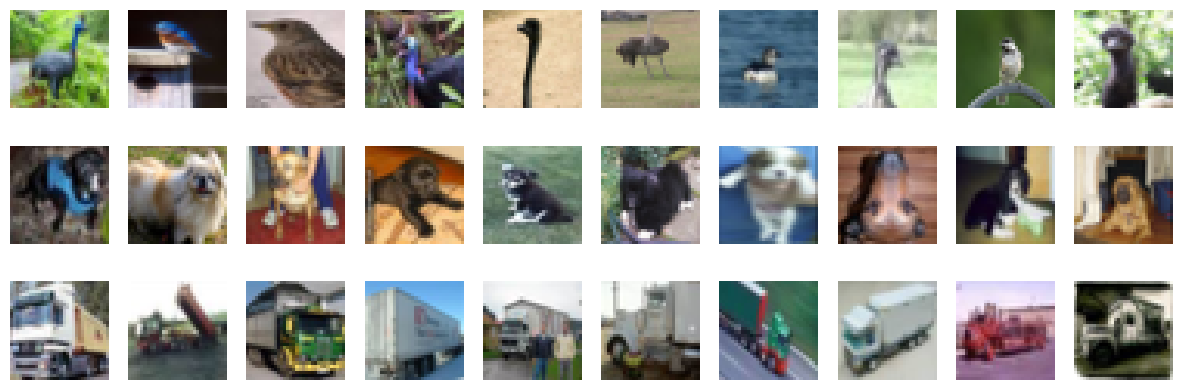

In [88]:
import matplotlib.pyplot as plt

print(f'Selected classes: {classes}')

fig = plt.figure(figsize=(15, 5))

for i, class_ in enumerate(classes):
    indices_class = [j for j, (image, label) in enumerate(train_subset) if label == class_][:10]
    for j, index in enumerate(indices_class):
        image, label = train_subset[index]
        image = image.numpy()
        image = image.transpose((1, 2, 0))
        ax = fig.add_subplot(3, 10, i*10 + j + 1)
        ax.axis('off')
        ax.imshow(image)

plt.show()


### Task 2 (15 marks): Build the autoencoder model using CNN with functioning training code (if not CNN based, 60% reduction of marks will incur for this task)

First, we define a convolutional neural network architecture. It follows the structure of an autoencoder which consists of three main parts: an encoder, a bottleneck, and a decoder. 

In the encoder part, it compress the input image into a lower-dimensional representation. The depth (number of channels) of the feature maps increases from 3 to 64 to 32 to 16, which can help the model learn more complex features. Each convolutional layer reduces the spatial dimensions of the input while increasing its depth. The kernel size of 3 and padding of 1 ensure that the spatial dimensions (height and width) of the output feature maps are the same as the input. The max pooling layers reduce the spatial dimensions by a factor of 2. 

In the bottleneck layers, it fully connect layers that further compress the encoded representation into just 2 units (a significant reduction from the original image size). This is the core latent representation of the input image. 

In the decoder part, it take the lower-dimensional representation from the encoder and recreate the original image. It consists of three transposed convolutional layers. These layers increase the spatial dimensions of the input while decreasing its depth.

In this scenario, we use the loss function that take the Mean Squared Error (MSE). The Adam optimizer is used to update the model's weights.

In [89]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.enc1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.fc1 = nn.Linear(16*4*4, 2)  
        self.fc2 = nn.Linear(2, 16*4*4)

        # Decoder
        self.dec1 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec2 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.dec3 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2)

    def encoder(self, x):
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        
        # Flatten and pass through the bottleneck
        x = x.view(-1, 16*4*4)
        x = self.fc1(x)
        return x

    def decoder(self, x):
        # Convert from 2 units to original flattened size and reshape
        x = self.fc2(x)
        x = x.view(-1, 16, 4, 4)
        
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = torch.sigmoid(self.dec3(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder model
autoencoder = Autoencoder()

# Set the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=1e-3)

# Train the model
# Epoch = Training size / Batch size = 300 / 10 = 30 times
for epoch in range(30):
    for data in trainloader:
        img, _ = data
        img.requires_grad_()
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Print loss
    print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')
    
print('Training completed.')

Epoch [1/5], Loss: 0.0642
Epoch [2/5], Loss: 0.0534
Epoch [3/5], Loss: 0.0499
Epoch [4/5], Loss: 0.0600
Epoch [5/5], Loss: 0.0420
Epoch [6/5], Loss: 0.0395
Epoch [7/5], Loss: 0.0391
Epoch [8/5], Loss: 0.0415
Epoch [9/5], Loss: 0.0379
Epoch [10/5], Loss: 0.0416
Epoch [11/5], Loss: 0.0400
Epoch [12/5], Loss: 0.0463
Epoch [13/5], Loss: 0.0385
Epoch [14/5], Loss: 0.0347
Epoch [15/5], Loss: 0.0397
Epoch [16/5], Loss: 0.0336
Epoch [17/5], Loss: 0.0326
Epoch [18/5], Loss: 0.0349
Epoch [19/5], Loss: 0.0318
Epoch [20/5], Loss: 0.0349
Epoch [21/5], Loss: 0.0462
Epoch [22/5], Loss: 0.0347
Epoch [23/5], Loss: 0.0309
Epoch [24/5], Loss: 0.0393
Epoch [25/5], Loss: 0.0343
Epoch [26/5], Loss: 0.0467
Epoch [27/5], Loss: 0.0407
Epoch [28/5], Loss: 0.0372
Epoch [29/5], Loss: 0.0413
Epoch [30/5], Loss: 0.0333
Training completed.


We can choose random image and use the trained `autoencoder` model to print the result. The expected output of this model is the reconstructed images.

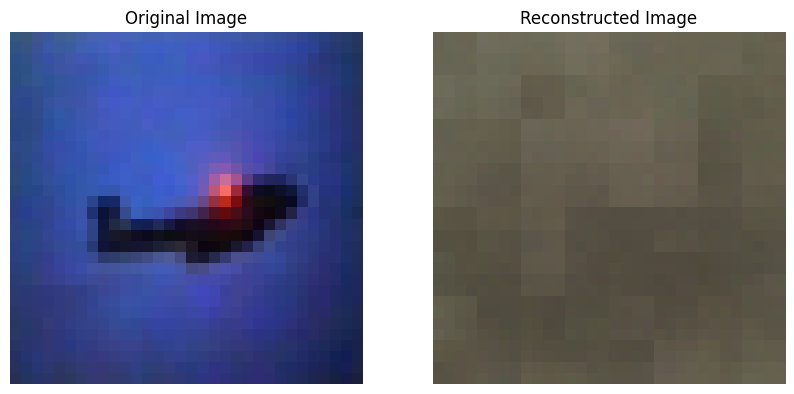

In [90]:
import matplotlib.pyplot as plt

# Randomly select an image from the dataset
random_index = np.random.randint(len(dataset))
random_image, _ = dataset[random_index]
random_image_tensor = random_image.unsqueeze(0).to(device)  

# Pass the image through the autoencoder
with torch.no_grad():
    reconstructed_image_tensor = autoencoder(random_image_tensor)
    if isinstance(reconstructed_image_tensor, tuple):
        reconstructed_image_tensor = reconstructed_image_tensor[0] 
    reconstructed_image = reconstructed_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)  


# visualise the original and reconstructed images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Original image
ax1.imshow(random_image.numpy().transpose(1, 2, 0))
ax1.set_title('Original Image')
ax1.axis('off')

# Reconstructed image
ax2.imshow(reconstructed_image)
ax2.set_title('Reconstructed Image')
ax2.axis('off')

plt.show()


### Task 3 (5 marks): Plot the learned images 2D coordinates (normally called embeddings in machine learning) of all images in training with each class denoted by a symbol, for example, circles for dogs, triangles for cats and so on

First, we extract embeddings and labels from the model using "for" loop that pass images through the encoder part of the autoencoder, which reduces the images into a lower-dimensional representation.

In [91]:
# Extract embeddings and labels from the model
embeddings = []
labels = []
for images, targets in trainloader:
    images = images.to(device)
    encoded = autoencoder.encoder(images)
    # Flatten the encoded images
    encoded_flattened = encoded.view(encoded.size(0), -1)
    embeddings.append(encoded_flattened.detach().cpu().numpy())
    labels.append(targets.numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

Second, we visualise the embeddings (compressed representations) learned by the autoencoder using a 2D scatter plot. The embeddings are projected to 2D using the t-SNE (t-distributed Stochastic Neighbor Embedding) method.

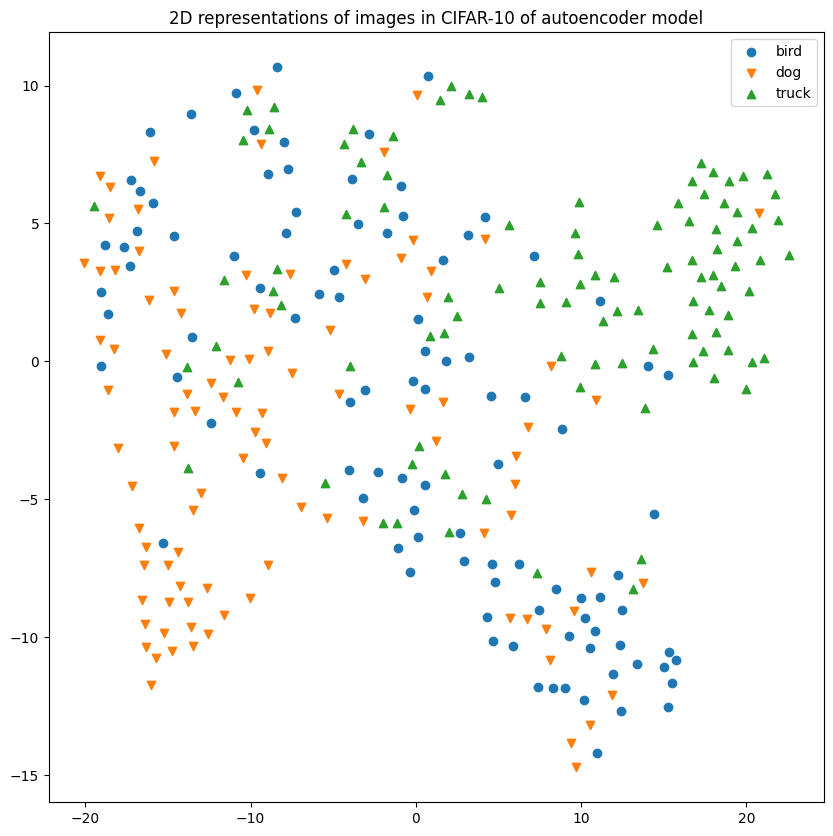

In [92]:
from sklearn.manifold import TSNE

def plot_embeddings(embeddings, targets, classes):
    embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)
    
    # Create a mapping from class index to marker
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    class_to_marker = {class_index: marker for class_index, marker in zip(classes, markers)}

    # Create a list of class labels for the selected classes
    labels = [index_to_class[class_] for class_ in classes]

    plt.figure(figsize=(10,10))
    for class_index, label in zip(classes, labels):
        plt.scatter(embeddings_2d[targets == class_index, 0], 
                    embeddings_2d[targets == class_index, 1], 
                    marker=class_to_marker[class_index], 
                    label=label)
    plt.legend()
    plt.title("2D representations of images in CIFAR-10 of autoencoder model")
    plt.show()

# Create a dictionary mapping from class indices to class names
index_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Plot the embeddings
plot_embeddings(embeddings, labels, classes)


### Task 4 (2 marks): Randomly select 5 images that are not in the training set and obtain their 2D representations, add them to the plot produced in task 3 and describe what do you think about them in terms of their locations in relations to others

We choose randomly 5 images from the CIFAR10 dataset but we need to make sure that 5 images must not overlap with the images used in the training set.

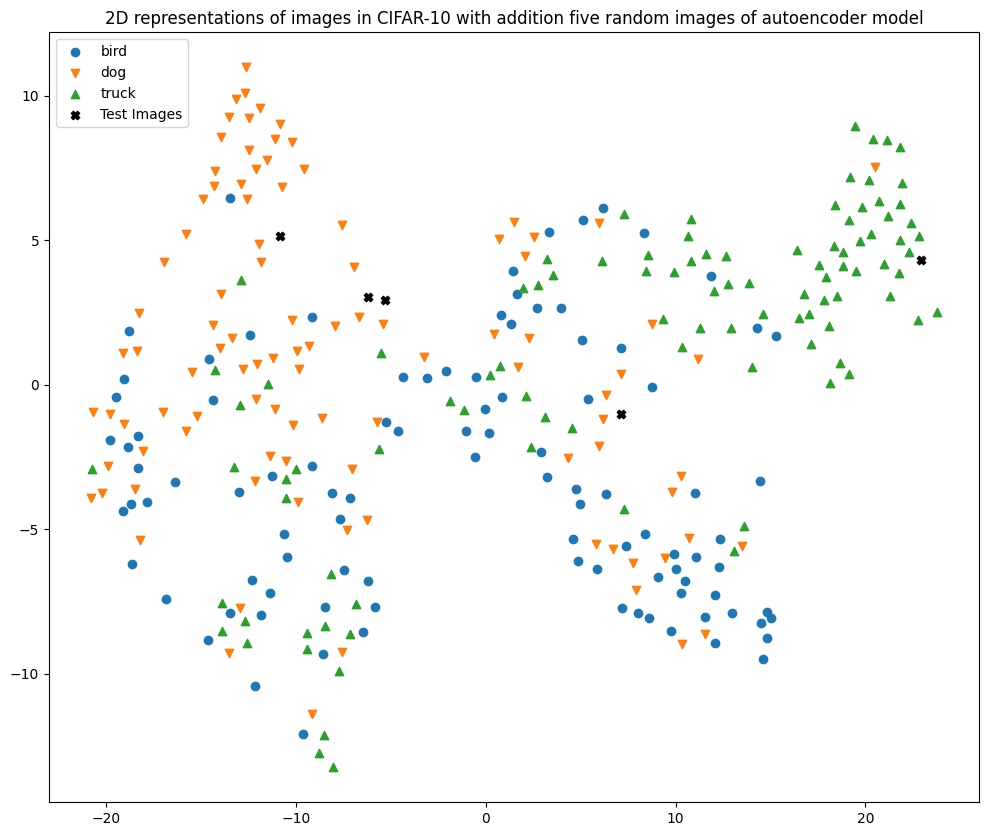

In [93]:
# Load CIFAR-10 test dataset
test_dataset = CIFAR10(dataset_path, train=False, download=False, transform=transforms.ToTensor())

# Extract all indices from the test_dataset
all_test_indices = set(range(len(test_dataset)))

# Remove the indices that are in the training set
available_test_indices = list(all_test_indices - set(indices))

# Randomly select 5 images from the available_test_indices
random_selected_indices = np.random.choice(available_test_indices, 5, replace=False)
selected_images, selected_labels = zip(*[test_dataset[i] for i in random_selected_indices])

# Convert selected images to a tensor batch
selected_images_tensor = torch.stack(selected_images).to(device)

# Pass these images through the autoencoder's encoder to get embeddings
with torch.no_grad():
    test_embeddings = autoencoder.encoder(selected_images_tensor)
    test_embeddings = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# Combine the embeddings of training data and the 5 test images
combined_embeddings = np.vstack([embeddings, test_embeddings])
combined_labels = np.concatenate([labels, np.array(selected_labels) - 10])  # Subtract 10 to differentiate test images from training images

# Get the 2D representations using t-SNE
combined_embeddings_2d = TSNE(n_components=2).fit_transform(combined_embeddings)

# Create a mapping from class index to marker
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
class_to_marker = {class_index: marker for class_index, marker in zip(classes, markers)}

# Create a fuction to visualise embedding
def plot_combined_embeddings(embeddings_2d, targets, classes):
    plt.figure(figsize=(12, 10))

    # Plot training data embeddings
    for class_index, label in zip(classes, [index_to_class[class_] for class_ in classes]):
        plt.scatter(embeddings_2d[targets == class_index, 0], 
                    embeddings_2d[targets == class_index, 1], 
                    marker=class_to_marker.get(class_index, 'o'), 
                    label=label)

    # Plot the 5 test images with a black X marker
    plt.scatter(embeddings_2d[targets < 0, 0], embeddings_2d[targets < 0, 1], marker='X', color='black', label='Test Images')

    plt.legend()
    plt.title("2D representations of images in CIFAR-10 with addition five random images of autoencoder model")
    plt.show()

# Plot the combined embeddings
plot_combined_embeddings(combined_embeddings_2d, combined_labels, classes)


#### Conclusion


The autoencoder model, when employing a CNN, learns to compress the input data and subsequently reconstructs the original data from this compressed form. However, an autoencoder may interpret noise as an authentic feature in its effort to closely replicate the data. As a result, as we can see from the plot, the generated embeddings are being influenced by this noise, complicating the task of data classification. 

Regarding to five additional random images, it can be seen that the images do not follow any specific pattern. As we observe from the plot, the five random images still lie within the range of the captured model. From the left to the right, five random images have their locations in relations to others respectively:

- The first random image is closest to a dog image and close to the dog cluster group.

- The second random image is closest to a dog image and close to the dog cluster group.

- The third random image is closest to a dog image and close to the dog cluster group.

- The fourth random image is closest to a dog image and close to the bird cluster group.

- The fifth random image is closest to a truck image and close to the truck cluster group.

## Bonus Task

<em>Build a supervised manifold learning model on CIFAR-10 images. The main idea is to incorporate labels information in the manifold learning process. It is very similar to LDA (linear discriminant analysis) in terms of functionality. However, instead of a linear function, we use neural networks autoencoder as the backbone for manifold learning. Therefore, The model is a combination of autoencoder and classification, i.e. incorporating supervision information in the modelling process, for example, adding classification cost function into original autoencoder cost function. Do task 1-4 (see above) but replace the autoencoder by this supervised one.</em>

### Task 1: Randomly select 3 classes with 100 images per class for this assignment

In [94]:
selected_classes = np.random.choice(np.unique(dataset.targets), 3, replace=False)
indices = []

for class_ in selected_classes:
    indices_class = np.where(np.array(dataset.targets) == class_)[0][:100]
    indices.extend(indices_class)

train_subset = Subset(train_data.dataset, indices)

# Create dataloaders
# "shuffle" parameter = True if the data use to train, "shuffle" parameter = False if the data use to test
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=10, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=False)

We can print the selected classes and its first 10 images to visualise.

Selected classes: [5 8 7]


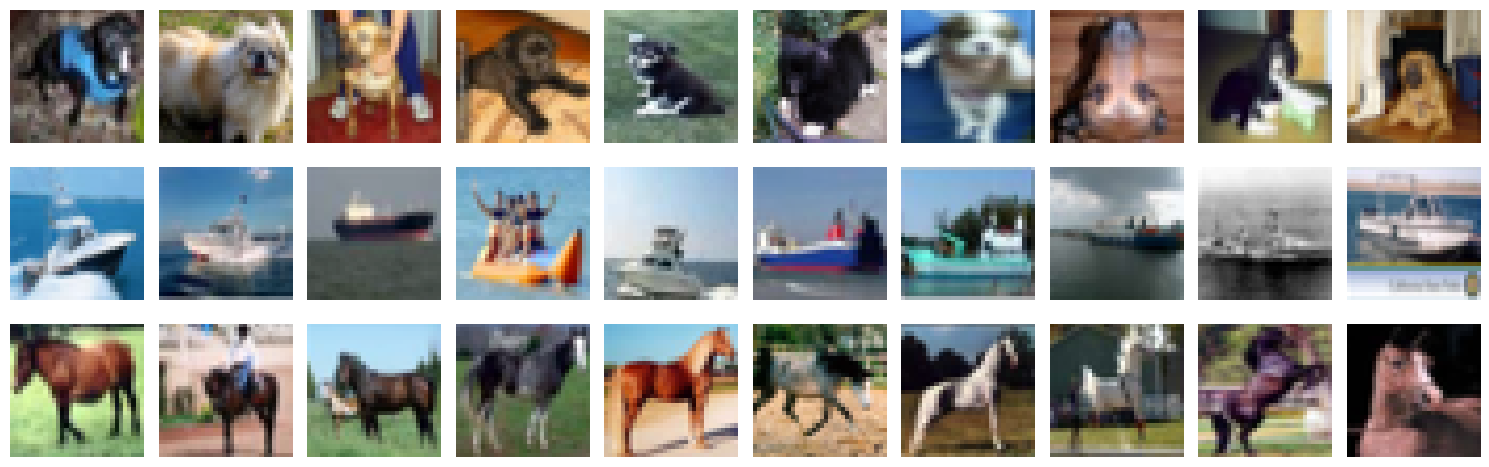

In [95]:
import matplotlib.pyplot as plt

print(f'Selected classes: {selected_classes}')

fig = plt.figure(figsize=(15, 5))

for i, class_ in enumerate(selected_classes):
    indices_class = [j for j, (image, label) in enumerate(train_subset) if label == class_][:10]
    for j, index in enumerate(indices_class):
        image, label = train_subset[index]
        image = image.numpy()
        image = (image - image.min()) / (image.max() - image.min()) 
        image = image.transpose((1, 2, 0))
        ax = fig.add_subplot(3, 10, i*10 + j + 1)
        ax.axis('off')
        ax.imshow(image)

plt.tight_layout()
plt.show()

### Task 2: Build a supervised manifold learning model on CIFAR-10 images

<em>The main idea is to incorporate labels information in the manifold learning process. It is very similar to LDA (linear discriminant analysis) in terms of functionality. However, instead of a linear function, we use neural networks autoencoder as the backbone for manifold learning.</em>

We build the architecture which is a combination of an autoencoder and a classifier. The `SupervisedAutoencoder` is made of four parts. 

First part encoder takes an input image and compresses it into a lower-dimensional representation. It consists of three convolutional layers with a max-pooling layer. Second part bottleneck is the compressed representation of the input. Third part decoder takes the lower-dimensional representation produced by the encoder and tries to recreate the original image. It consists of three transposed convolutional layers. After encoding the image, instead of just decoding it, the compressed representation is also passed through a linear layer (classifier) to predict class labels.

In this case, we use Cross-Entropy Loss (classification loss between the predicted class labels and the true labels) to update the model's parameters. 

In [96]:
class SupervisedAutoencoder(nn.Module):
    def __init__(self, num_classes=10):
        super(SupervisedAutoencoder, self).__init__()

        # Encoder
        self.enc1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.fc1 = nn.Linear(16*4*4, 2)
        self.fc2 = nn.Linear(2, 16*4*4)

        # Decoder
        self.dec1 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec2 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.dec3 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2)

        # Classifier
        self.classifier = nn.Linear(16*2*2, num_classes)

    def encoder(self, x):
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        
        # Flatten and pass through the bottleneck
        x = x.view(-1, 16*4*4)
        x = self.fc1(x)
        return x

    def decoder(self, x):
        x = self.fc2(x)
        x = x.view(-1, 16, 4, 4)
        
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = torch.sigmoid(self.dec3(x))
        return x

    def forward(self, x):
        encoding = self.encoder(x)
        
        # Decoder path
        reconstructed_img = self.decoder(encoding)
        
        # Classification path
        clf_input = self.fc2(encoding).view(encoding.size(0), 16, 4, 4)
        clf_input = self.pool(clf_input)
        clf = F.softmax(self.classifier(clf_input.view(clf_input.size(0), -1)), dim=1)

        return reconstructed_img, clf

# Initialize the supervised autoencoder model
model = SupervisedAutoencoder(num_classes=3)

# Define the loss function and the optimizer
classification_criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

# Training loop
# Epoch = Training size / Batch size = 300 / 10 = 30 times
num_epochs = 30
for epoch in range(num_epochs):
    for img, labels in trainloader:
        # Zero the gradients
        optimizer.zero_grad()

        _, class_outputs = model(img)
        
        # Convert labels to match the new class indices
        labels = torch.tensor([selected_classes.tolist().index(l) for l in labels])
        
        classification_loss = classification_criterion(class_outputs, labels)

        # Backward pass and optimize
        classification_loss.backward()
        optimizer.step()

    # Print the loss values
    print(f'Epoch [{epoch+1}/{num_epochs}], Classification Loss: {classification_loss.item():.4f}')

print("Training completed!")


Epoch [1/30], Classification Loss: 1.1007
Epoch [2/30], Classification Loss: 0.9942
Epoch [3/30], Classification Loss: 1.1250
Epoch [4/30], Classification Loss: 1.1772
Epoch [5/30], Classification Loss: 0.9852
Epoch [6/30], Classification Loss: 0.9956
Epoch [7/30], Classification Loss: 0.9216
Epoch [8/30], Classification Loss: 0.8566
Epoch [9/30], Classification Loss: 0.8812
Epoch [10/30], Classification Loss: 0.8608
Epoch [11/30], Classification Loss: 0.9658
Epoch [12/30], Classification Loss: 0.6909
Epoch [13/30], Classification Loss: 0.7803
Epoch [14/30], Classification Loss: 0.9929
Epoch [15/30], Classification Loss: 0.9353
Epoch [16/30], Classification Loss: 0.7022
Epoch [17/30], Classification Loss: 0.6709
Epoch [18/30], Classification Loss: 0.7441
Epoch [19/30], Classification Loss: 0.9530
Epoch [20/30], Classification Loss: 0.6878
Epoch [21/30], Classification Loss: 0.6480
Epoch [22/30], Classification Loss: 0.7739
Epoch [23/30], Classification Loss: 0.7503
Epoch [24/30], Class

We can use a random image of the dataset to test the model. Expected output of this model is reconstructed image and the predicted class.

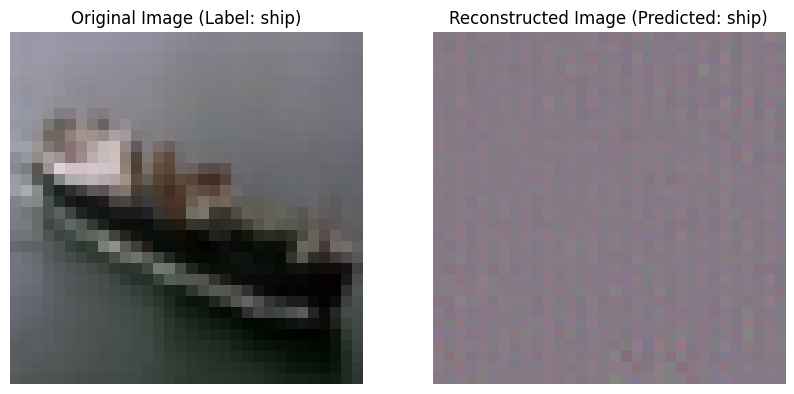

In [97]:
import matplotlib.pyplot as plt

# Select a random image from the dataset
random_index = np.random.randint(len(dataset))
random_image, true_label = dataset[random_index]
random_image_tensor = random_image.unsqueeze(0)  # Add batch dimension

# Pass the image through the model
with torch.no_grad():
    reconstructed_image, class_outputs = model(random_image_tensor)
    _, predicted_label = torch.max(class_outputs, 1)  # Get the index of the maximum value

# Convert tensor image to numpy for visualisation
reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)

# visualise the original and reconstructed images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Original image
ax1.imshow(random_image.numpy().transpose(1, 2, 0))
ax1.set_title(f'Original Image (Label: {index_to_class[true_label]})')
ax1.axis('off')

# Reconstructed image
ax2.imshow(reconstructed_image)
ax2.set_title(f'Reconstructed Image (Predicted: {index_to_class[selected_classes[predicted_label.item()]]})')
ax2.axis('off')

plt.show()


### Task 3: Plot the learned images 2D coordinates of all images in training with each class denoted by a symbol

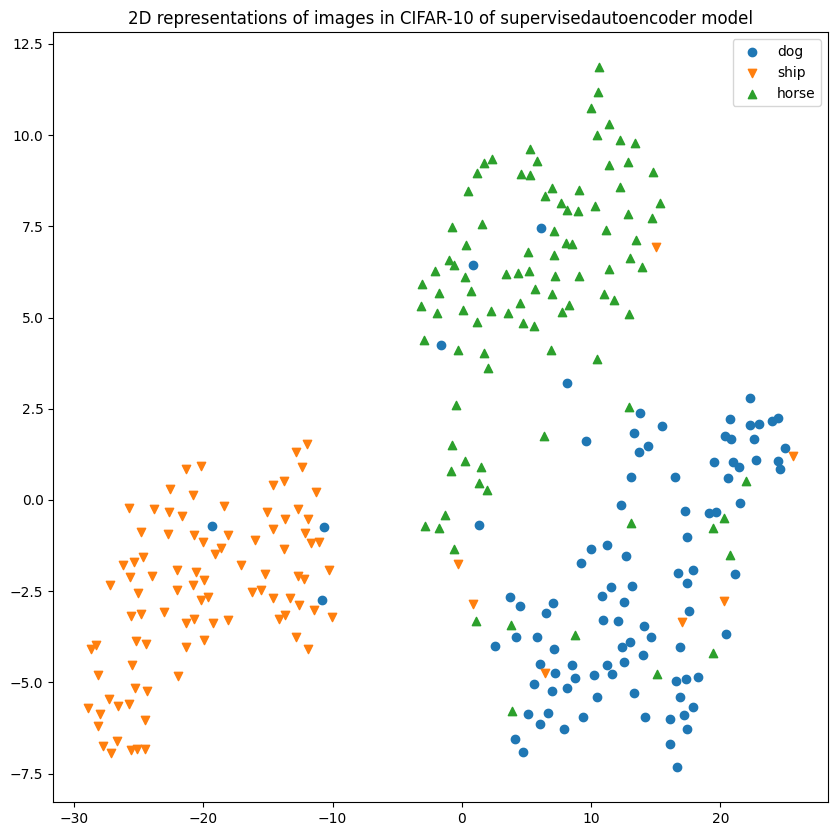

In [98]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

embeddings = []

extracted_labels = []

with torch.no_grad():
    for img, labels in trainloader:
        encoding = model.encoder(img)
        embeddings.append(encoding.view(encoding.size(0), -1).cpu().numpy())
        extracted_labels.extend(labels.cpu().numpy())

embeddings = np.vstack(embeddings)

filtered_embeddings = embeddings[np.isin(extracted_labels, selected_classes)]
filtered_labels = np.array(extracted_labels)[np.isin(extracted_labels, selected_classes)]

def plot_embeddings(embeddings, targets, selected_classes):
    embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)
    
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    class_to_marker = {class_index: marker for class_index, marker in zip(selected_classes, markers)}

    labels = [index_to_class[class_] for class_ in selected_classes]

    plt.figure(figsize=(10,10))
    for class_index, label in zip(selected_classes, labels):
        plt.scatter(embeddings_2d[targets == class_index, 0], 
                    embeddings_2d[targets == class_index, 1], 
                    marker=class_to_marker[class_index], 
                    label=label)
    plt.legend()
    plt.title("2D representations of images in CIFAR-10 of supervisedautoencoder model")
    plt.show()

autoencoder = model
autoencoder.eval()

index_to_class = {i: class_name for i, class_name in enumerate(dataset.classes)}

plot_embeddings(filtered_embeddings, filtered_labels, selected_classes)

### Task 4: Randomly select 5 images that are not in the training set and obtain their 2D representations, add them to the plot produced in task 3 and describe what do you think about them in terms of their locations in relations to others



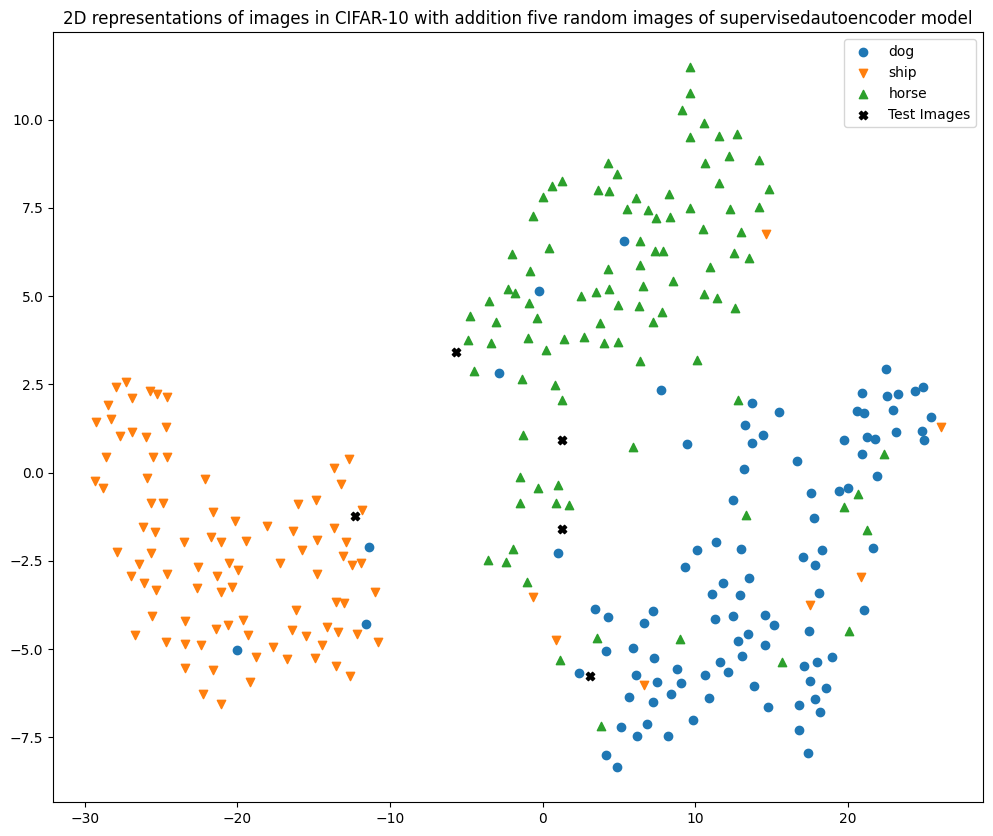

In [99]:
# Load CIFAR-10 test dataset
test_dataset = CIFAR10(dataset_path, download=False, transform=transforms.ToTensor())

# Extract all indices from the test_dataset
all_test_indices = set(range(len(test_dataset)))

# Remove the indices that are in the training set
available_test_indices = list(all_test_indices - set(indices))

# Randomly select 5 images from the available_test_indices
random_selected_indices = np.random.choice(available_test_indices, 5, replace=False)
selected_images, selected_labels = zip(*[test_dataset[i] for i in random_selected_indices])

# Convert the list of images to a tensor batch
selected_images_tensor = torch.stack(selected_images)

# Pass these images through the model's encoder to get embeddings
with torch.no_grad():
    test_embeddings = model.encoder(selected_images_tensor)
    test_embeddings = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# Apply t-SNE to obtain 2D representations
test_embeddings_2d = TSNE(n_components=2).fit_transform(np.vstack([embeddings, test_embeddings]))

# Separate the embeddings of the training data and the 5 test images
train_embeddings_2d = test_embeddings_2d[:-5]
test_embeddings_2d = test_embeddings_2d[-5:]

markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
class_to_marker = {class_index: marker for class_index, marker in zip(selected_classes, markers)}

# Plot the embeddings of the training data and the 5 test images
plt.figure(figsize=(12, 10))

# Plot training data embeddings
for class_index, label in zip(selected_classes, [index_to_class[class_] for class_ in selected_classes]):
    plt.scatter(train_embeddings_2d[filtered_labels == class_index, 0], 
                train_embeddings_2d[filtered_labels == class_index, 1], 
                marker=class_to_marker[class_index],
                label=label)

# Plot the 5 test images with a special marker (e.g., black X)
plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], marker='X', color='black', label='Test Images')

plt.legend()
plt.title("2D representations of images in CIFAR-10 with addition five random images of supervisedautoencoder model")
plt.show()


#### Conclusion


The supervised manifold learning model does more than merely reconstruct its input; it also classifies it. As a result, the data exhibits more pronounced patterns, and cluster boundaries become more distinct. In the SupervisedAutoencoder model, the presence of a classifier ensures that cluster groupings remain largely unaffected by noisy data, leading to clearer and more accurate predictions.

Concerning the five random images, from left to right, the images have their locations in relations to others respectively:

- The first random image is closest to ship image and close to the ship cluster group. 

- The second random image is closest to horse image and close to the horse cluster group.

- The third random image is closest to horse image and close to the horse cluster group.

- The fourth random image is closest to horse image and close to the horse cluster group.

- The fifth random image is closest to dog image and close to the dog cluster group.